# Similar Product Recommendations
> A tutorial on building a recommender system that will find similar looking products

- toc: true
- badges: true
- comments: true
- categories: [similarity vision]
- image:

In [1]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Passo 1: Configuração do Ambiente e Carregamento dos Dados


Nesta primeira etapa, preparamos o ambiente do Google Colab para execução e carregamos nosso conjunto de imagens. As ações realizadas são:
1.  **Conexão com o Google Drive:** Montamos o Google Drive para garantir a persistência dos nossos dados (dataset, modelos salvos, índices). Isso evita a perda de arquivos importantes quando a sessão do Colab é encerrada.
2.  **Carregamento e Extração do Dataset:** Descompactamos nosso conjunto de imagens (arquivo `.rar`) do Google Drive para o ambiente local do Colab, tornando-o pronto para o processamento.

In [2]:
# Instala o unrar
!pip install unrar
!sudo apt-get install -y unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
# Descompacta o dataset do Drive para o ambiente do Colab
caminho_do_rar = '/content/drive/My Drive/colab_notebooks/dataset_produtos.rar'
pasta_destino = '/content/imagens/'
!unrar x "{caminho_do_rar}" "{pasta_destino}"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/My Drive/colab_notebooks/dataset_produtos.rar


Would you like to replace the existing file /content/imagens/dataset_produtos/calca01.jpg
621960 bytes, modified on 2025-09-20 23:56
with a new one
621960 bytes, modified on 2025-09-20 23:56

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit n


Would you like to replace the existing file /content/imagens/dataset_produtos/calca02.jpg
 39132 bytes, modified on 2025-09-20 23:57
with a new one
 39132 bytes, modified on 2025-09-20 23:57

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit q

Program aborted


## Passo 2: Vetorização das Imagens com Transfer Learning

Esta é a etapa central do projeto, onde transformamos informações visuais em dados numéricos que o computador pode comparar.

- **O que é Vetorização?** É o processo de converter uma imagem em um vetor (uma longa lista de números), também conhecido como *embedding*. Este vetor representa as características essenciais da imagem, como formas, cores e texturas.
- **Como funciona?** Usamos um poderoso modelo de Deep Learning pré-treinado (**Google BiT M-R50x3/1**) disponível no TensorFlow Hub. Como o modelo já foi treinado com milhões de imagens, ele "sabe" como extrair essas características de forma muito eficaz. Esse processo é chamado de **Transfer Learning**.


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm

# 1. Carregar o Modelo Pré-treinado
print("Carregando o modelo do TensorFlow Hub...")
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
model = hub.load(MODULE_HANDLE)
print("Modelo pré-treinado carregado com sucesso!")

# 2. Listar TODAS as suas Imagens
# --- ATENÇÃO: VERIFIQUE ESTE CAMINHO ---
# Certifique-se de que este caminho corresponde à pasta onde suas imagens estão.
# Se a pasta dentro do seu arquivo .rar se chamava 'dataset_produtos', este caminho está correto.
image_dir = Path('/content/imagens/dataset_produtos/')
img_paths = list(image_dir.glob('*.*'))
print(f"\nEncontradas {len(img_paths)} imagens no seu dataset.")


# 3. Definir a Função de Carregamento de Imagem
# Esta função prepara a imagem para ser entendida pelo modelo
def load_img(path):
    img = tf.io.read_file(path)
    # Use decode_image to handle various image formats
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
    img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    return img


# 4. Executar a Vetorização (O Loop Principal)
# Cria uma pasta para salvar os vetores
imgvec_path = Path('/content/image_vectors/')
imgvec_path.mkdir(parents=True, exist_ok=True)

print("\nIniciando a vetorização das imagens... (Isso pode levar alguns minutos)")
# Este loop processa cada imagem e salva seu vetor correspondente
for filename in tqdm(img_paths):
    try:
        img = load_img(str(filename))
        features = model(img)  # Extrai as características
        feature_set = np.squeeze(features)  # Simplifica o formato do vetor

        # Define o nome do arquivo de saída (ex: imagem1.npz)
        outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
        out_path = imgvec_path / outfile_name

        # Salva o vetor de características em um arquivo
        np.savetxt(out_path, feature_set, delimiter=',')
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue # Skip to the next file if an error occurs


print("\n\033[1mVetorização concluída com sucesso!\033[0m")
print(f"Todos os {len(img_paths)} vetores foram salvos na pasta: {imgvec_path}")

Carregando o modelo do TensorFlow Hub...
Modelo pré-treinado carregado com sucesso!

Encontradas 95 imagens no seu dataset.

Iniciando a vetorização das imagens... (Isso pode levar alguns minutos)


 79%|███████▉  | 75/95 [00:12<00:01, 10.41it/s]

Error processing file /content/imagens/dataset_produtos/sapato06.jpg: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


100%|██████████| 95/95 [00:15<00:00,  6.29it/s]


Vetorização concluída com sucesso!
Todos os 95 vetores foram salvos na pasta: /content/image_vectors


## Passo 3: Indexação dos Vetores para Busca Rápida

Com milhares de vetores, comparar uma nova imagem com todas as outras do dataset uma por uma seria muito lento. Para resolver isso, precisamos de um sistema de busca otimizado.

- **Qual a solução?** Utilizamos a biblioteca `Annoy` (Approximate Nearest Neighbors Oh Yeah).
- **O que ela faz?** O Annoy constrói uma estrutura de dados chamada índice, que organiza os vetores de forma inteligente. Isso permite encontrar os vetores mais similares (os "vizinhos mais próximos") de forma quase instantânea, mesmo em um grande volume de dados.

Nesta etapa, o código irá carregar todos os vetores que criamos no passo anterior e construir este índice. O índice (`index.ann`) e um arquivo de mapeamento (que liga cada vetor ao seu nome de arquivo original) são salvos no Google Drive.

In [4]:
!pip install annoy

import os
import numpy as np
import pickle
from tqdm import tqdm
from annoy import AnnoyIndex

# --- Configurações ---
# Caminho para a pasta com os vetores de imagem
VECTORS_DIR = '/content/image_vectors/'

# Caminho no seu Google Drive para salvar o índice final
# Vamos criar uma pasta para organizar o projeto
DRIVE_PROJECT_PATH = '/content/drive/My Drive/colab/notebooks/projeto_recomendacao/'
os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)

# Parâmetros do Annoy
dims = 6144 # A dimensão dos vetores do modelo BiT que usamos
n_nearest_neighbors = 20
trees = 10000

# --- Lógica Principal ---
all_files = os.listdir(VECTORS_DIR)
print(f"Encontrados {len(all_files)} vetores para indexar.")

# Dicionário para mapear o ID do índice (0, 1, 2...) ao nome original da imagem
file_index_to_file_name = {}

# Criando o índice Annoy
t = AnnoyIndex(dims, metric='angular')

# Loop para ler cada vetor e adicionar ao índice
for findex, fname in enumerate(tqdm(all_files)):
    vector_path = os.path.join(VECTORS_DIR, fname)
    file_vector = np.loadtxt(vector_path)

    original_fname = os.path.basename(fname).replace(".npz", "")
    file_index_to_file_name[findex] = original_fname

    t.add_item(findex, file_vector)

# Constrói o índice (pode levar alguns minutos)
print("\nConstruindo o índice Annoy...")
t.build(trees)
print("Índice construído com sucesso!")

# Salva o índice e o dicionário no Google Drive
index_path = os.path.join(DRIVE_PROJECT_PATH, 'index.ann')
mapping_path = os.path.join(DRIVE_PROJECT_PATH, 'file_mapping.pkl')

t.save(index_path)
with open(mapping_path, 'wb') as f:
    pickle.dump(file_index_to_file_name, f)

print(f"Índice salvo em: {index_path}")
print(f"Mapeamento salvo em: {mapping_path}")

Encontrados 94 vetores para indexar.


100%|██████████| 94/94 [00:00<00:00, 324.10it/s]



Construindo o índice Annoy...
Índice construído com sucesso!
Índice salvo em: /content/drive/My Drive/colab/notebooks/projeto_recomendacao/index.ann
Mapeamento salvo em: /content/drive/My Drive/colab/notebooks/projeto_recomendacao/file_mapping.pkl


## Passo 4: Teste de Similaridade (Prova de Conceito)

Antes de construir a aplicação final, é fundamental verificar se nosso sistema de busca está funcionando como esperado. Este passo serve como uma prova de conceito rápida.

O código irá:
1.  Carregar o índice `Annoy` e o mapeamento salvos no Google Drive.
2.  Selecionar uma imagem aleatória do nosso dataset para usar como consulta.
3.  Utilizar o índice para encontrar as 5 imagens mais similares.
4.  Exibir a imagem de consulta e as imagens recomendadas, permitindo uma validação visual da qualidade das recomendações.

--- Imagem de Busca: relogio10.jpg ---


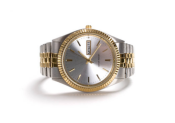


--- 5 Recomendações Similares ---


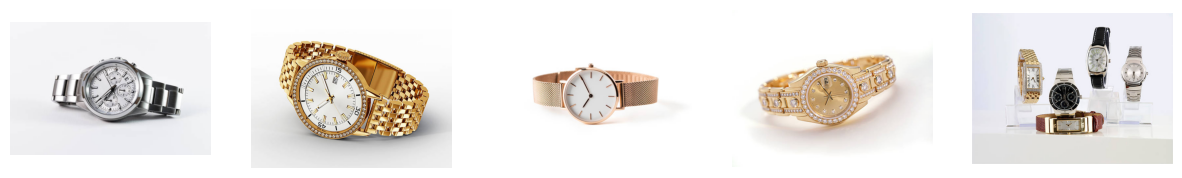

In [5]:
import numpy as np
import pickle
from annoy import AnnoyIndex
from PIL import Image
import matplotlib.pyplot as plt

# --- Carregar os arquivos salvos ---
DRIVE_PROJECT_PATH = '/content/drive/My Drive/colab/notebooks/projeto_recomendacao/'
index_path = os.path.join(DRIVE_PROJECT_PATH, 'index.ann')
mapping_path = os.path.join(DRIVE_PROJECT_PATH, 'file_mapping.pkl')

# Carrega o mapeamento
with open(mapping_path, 'rb') as f:
    file_index_to_file_name = pickle.load(f)

# Carrega o índice Annoy
dims = 6144
loaded_index = AnnoyIndex(dims, metric='angular')
loaded_index.load(index_path)

# --- Fazer a Busca ---
# Escolha uma imagem do seu dataset para testar
# --- ATENÇÃO: MUDE O NOME DO ARQUIVO ABAIXO ---
test_image_name = 'relogio10.jpg' # Coloque aqui o nome de um dos seus arquivos de imagem

# Caminhos
IMAGES_DIR = '/content/imagens/dataset_produtos/'
VECTORS_DIR = '/content/image_vectors/'

test_image_path = os.path.join(IMAGES_DIR, test_image_name)
test_vector_path = os.path.join(VECTORS_DIR, test_image_name.replace('.jpg', '.npz')) # Adapte se usar .png, etc.

# Carrega o vetor da imagem de teste
test_vector = np.loadtxt(test_vector_path)
top_k = 5 # Quantos vizinhos mais próximos queremos encontrar

# Busca no índice
result_indices = loaded_index.get_nns_by_vector(test_vector, top_k + 1, include_distances=False)

# Remove o primeiro resultado se ele for a própria imagem de busca
if file_index_to_file_name[result_indices[0]] in test_image_name:
    result_indices = result_indices[1:]
else:
    result_indices = result_indices[:top_k]

print(f"--- Imagem de Busca: {test_image_name} ---")
# Exibe a imagem de busca
plt.figure(figsize=(2, 2))
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.show()

print(f"\n--- {top_k} Recomendações Similares ---")
# Exibe as imagens recomendadas
fig, axes = plt.subplots(1, top_k, figsize=(15, 3))
for i, idx in enumerate(result_indices):
    fname_base = file_index_to_file_name[idx]
    # Encontra a extensão original (.jpg, .png, etc)
    original_path = [p for p in img_paths if fname_base in str(p)][0]

    img = Image.open(original_path)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

## Passo 5: Criação e Lançamento da Aplicação Web

Esta é a etapa final, onde unimos tudo em uma aplicação web interativa para que qualquer pessoa possa usar nosso sistema de recomendação.

### 5.1 - Escrevendo o Código da Aplicação com Streamlit

Utilizamos a biblioteca `Streamlit`, uma ferramenta poderosa para criar aplicações de dados de forma rápida e intuitiva. O código abaixo não é executado diretamente, mas sim usado para criar um arquivo `app.py` no ambiente do Colab.

Este script `app.py` contém toda a lógica da aplicação:
-   Carrega o índice `Annoy` e o modelo do TensorFlow.
-   Cria a interface do usuário com um título e um botão para upload de arquivos.
-   Quando um usuário envia uma imagem, ela é processada, vetorizada, e usada para consultar o índice.
-   As imagens mais similares são encontradas e exibidas na tela para o usuário.

### 5.2 - Lançando a Aplicação com Ngrok

Como nossa aplicação está rodando dentro do ambiente Colab, ela não é acessível publicamente. Para resolver isso, usamos o `Ngrok`.

-   **O que o Ngrok faz?** Ele cria um túnel seguro entre a nossa aplicação rodando localmente no Colab e um endereço web público (`...ngrok-free.app`).

O código a seguir irá iniciar o servidor Streamlit em segundo plano e, em seguida, gerar o link público para você acessar e testar a aplicação final em seu navegador.

In [6]:
!pip install -q streamlit pyngrok

In [7]:
%%writefile app.py

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Esta linha desativa a GPU para o TensorFlow
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pickle
from annoy import AnnoyIndex
import os




# --- Configurações e Carregamento dos Modelos ---
st.set_page_config(layout="wide")

@st.cache_resource
def load_models_and_data():
    DRIVE_PROJECT_PATH = '/content/drive/My Drive/colab/notebooks/projeto_recomendacao/'
    index_path = os.path.join(DRIVE_PROJECT_PATH, 'index.ann')
    mapping_path = os.path.join(DRIVE_PROJECT_PATH, 'file_mapping.pkl')

    with open(mapping_path, 'rb') as f:
        file_index_to_file_name = pickle.load(f)

    dims = 6144
    search_index = AnnoyIndex(dims, metric='angular')
    search_index.load(index_path)

    # Carrega o extrator de características
    model_handle = 'https://tfhub.dev/google/bit/m-r50x3/1'
    feature_extractor = hub.load(model_handle)

    return file_index_to_file_name, search_index, feature_extractor

file_index_to_file_name, search_index, feature_extractor = load_models_and_data()

IMAGES_DIR = '/content/imagens/dataset_produtos/'

def load_img(img_bytes):
    img = tf.io.decode_image(img_bytes, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
    img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    return img

# --- Interface do Streamlit ---
st.title("Sistema de Recomendação de Produtos por Imagem")

uploaded_file = st.file_uploader("Escolha uma imagem de um produto...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    bytes_data = uploaded_file.getvalue()

    col1, col2 = st.columns([1, 3])

    with col1:
        st.image(bytes_data, caption='Imagem Enviada', use_column_width=True)

    with col2:
        st.write("Encontrando produtos similares...")

        # Extrai características da imagem enviada
        query_vector = np.squeeze(feature_extractor(load_img(bytes_data)))

        # Busca no índice
        top_k = 5
        result_indices = search_index.get_nns_by_vector(query_vector, top_k)

        # Mostra os resultados
        st.write(f"**Top {top_k} Recomendações:**")

        result_cols = st.columns(top_k)

        for i, idx in enumerate(result_indices):
            fname_base = file_index_to_file_name[idx]

            # Encontra o caminho completo da imagem original
            # Esta parte é um pouco lenta, mas funciona para a demo
            found_path = None
            for ext in ['.jpg', '.png', '.jpeg']:
                potential_path = os.path.join(IMAGES_DIR, fname_base + ext)
                if os.path.exists(potential_path):
                    found_path = potential_path
                    break

            if found_path:
                with result_cols[i]:
                    result_img = Image.open(found_path)
                    st.image(result_img, use_column_width=True)

Overwriting app.py


In [8]:
# --- CÉLULA DE AUTENTICAÇÃO DO NGROK ---
# Cole aqui o comando que você copiou do site do ngrok
!ngrok config add-authtoken 32zNQR73vmpxXbkuWgJQ2vAS2JO_58Ww1AMkmph4J5H9MnsQP

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [9]:
from pyngrok import ngrok

# Mata qualquer túnel ngrok anterior
!kill $(ps aux | grep 'ngrok' | awk '{print $2}')

^C


In [10]:
# Inicia o streamlit em segundo plano
!streamlit run app.py &>/dev/null&

In [11]:
# Cria um túnel público para a porta do streamlit
public_url = ngrok.connect(8501)
print(f"Clique no link para abrir a aplicação: {public_url}")

Clique no link para abrir a aplicação: NgrokTunnel: "https://6bb87bb7fbc3.ngrok-free.app" -> "http://localhost:8501"


In [43]:
# Ridar o Streamlit de forma visível para ver os logs e possíveis erros
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.120.219:8501

  Stopping...


### Streamlit App

In [ ]:
%%writefile app.py
### ----app.py---- ###

import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer

root_path = '/content/drive/MyDrive/ImgSim'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(os.path.join(root_path, 'styles.csv'))

# load the mappings
file_index_to_file_name = pickle.load(open(os.path.join(root_path ,'file_index_to_file_name.p'), 'rb'))
file_index_to_file_vector = pickle.load(open(os.path.join(root_path ,'file_index_to_file_vector.p'), 'rb'))
file_index_to_product_id = pickle.load(open(os.path.join(root_path ,'file_index_to_product_id.p'), 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

st.title("Image Similarity App")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    image.save(query_path)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Top similar images...")

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = []
    img_captions = []

    start_time = time.time()
    for i in nns:
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files.append(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions.append(img_caption)
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    st.image(img_files, caption=img_captions, width=200)

Writing app.py


In [ ]:
! pip install -q pyngrok
! pip install -q streamlit
! pip install -q colab-everything

from colab_everything import ColabStreamlit
ColabStreamlit('app.py')

### Flask API

#### server-side

In [ ]:
%%writefile flask_app.py
### ----flask_app.py---- ###

import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer
import io
import base64

from flask import Flask, request, jsonify, send_file

_PPATH = '/content/drive/MyDrive/ImgSim/'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(_PPATH+'styles.csv')

# load the mappings
file_index_to_file_name = pickle.load(open(_PPATH+'file_index_to_file_name.p', 'rb'))
file_index_to_file_vector = pickle.load(open(_PPATH+'file_index_to_file_vector.p', 'rb'))
file_index_to_product_id = pickle.load(open(_PPATH+'file_index_to_product_id.p', 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

def get_encoded_img(img):
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    my_encoded_img = base64.encodebytes(img_byte_arr.getvalue()).decode('ascii')
    return my_encoded_img


app = Flask(__name__)

@app.route("/fashion", methods=["POST"])
def home():
    file = request.files['image']
    # Read the image via file.stream
    img = Image.open(file.stream)
    img.save(query_path)

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = {}
    img_captions = {}

    start_time = time.time()
    for count, i in enumerate(nns):
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files[count] = get_encoded_img(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions[count] = img_caption
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    return jsonify(img_files)

app.run(debug=True)

In [ ]:
!nohup python3 -u flask_app.py &

nohup: appending output to 'nohup.out'


#### client-side

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import requests

!wget -O 'img.jpg' -q 'https://images-na.ssl-images-amazon.com/images/I/61utX8kBDlL._UL1100_.jpg'

url = 'http://localhost:5000/fashion'
my_img = {'image': open('img.jpg', 'rb')}
r = requests.post(url, files=my_img)

imgs = []
for i in range(6):
  img = base64.decodebytes(r.json()[str(i)].encode('ascii'))
  img = Image.open(BytesIO(img)).convert('RGBA')
  imgs.append(img)

imgs[1]

## Step 7: Deployment on AWS Elastic BeanStalk

The API was deployed on AWS cloud infrastructure using AWS Elastic Beanstalk service.

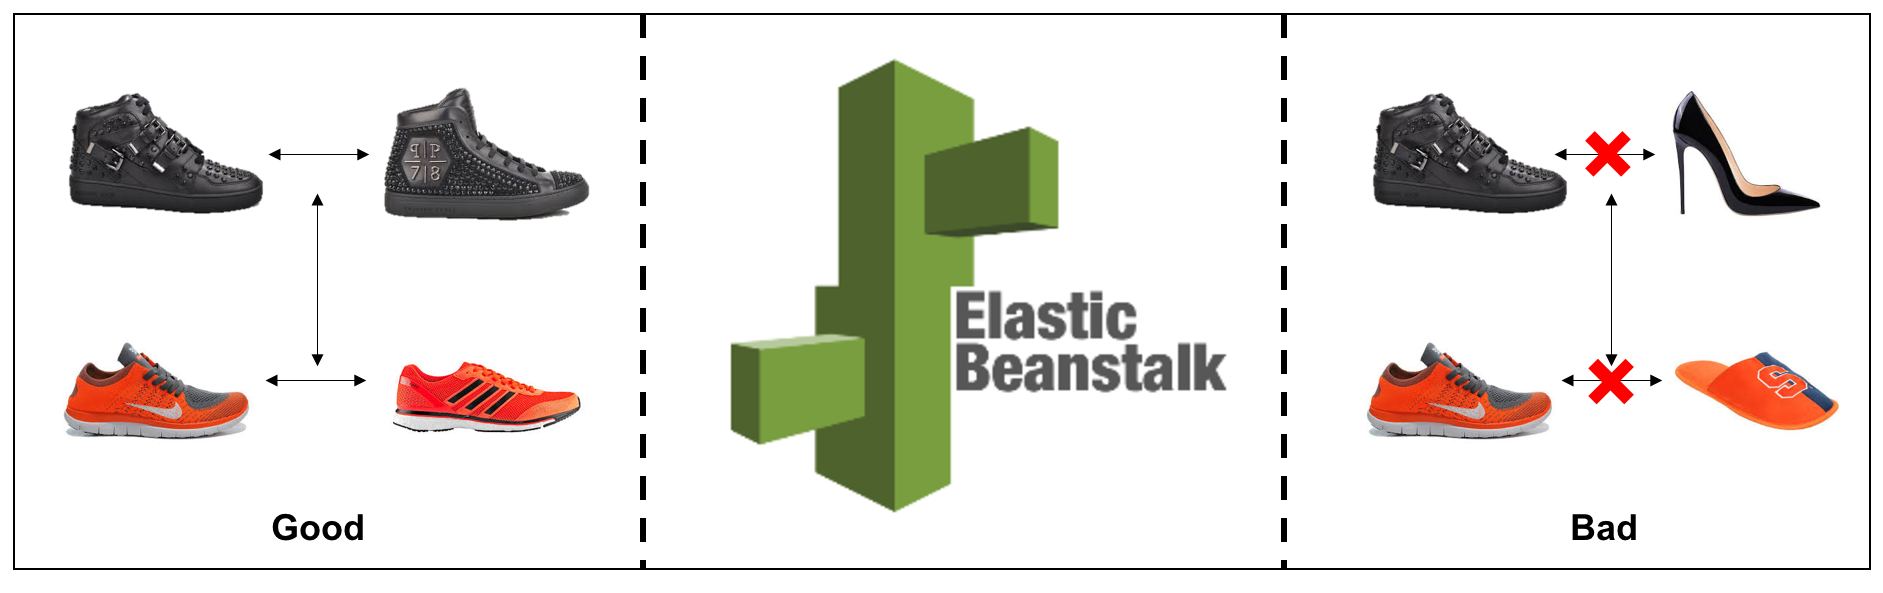

### application.py

In [ ]:
#collapse
%%writefile ./ebsapp/application.py
import os
import zipfile
import requests
from tqdm import tqdm
from shutil import move
from pandas import read_csv
from pathlib import Path
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import glob
import json
from tqdm import tqdm
from annoy import AnnoyIndex
from scipy import spatial
import pickle
import time
from PIL import Image
import tarfile
import io
import base64
from flask import Flask, request, jsonify, send_file
from flask import redirect, url_for, flash, render_template

# path = Path(__file__)
# _PPATH = str(path.parents[1])+'/'
_PPATH = os.path.join(os.getcwd(), 'mytemp')

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
module = hub.load(module_handle)

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

topK = 5
threshold = 0.3
UPLOAD_FOLDER = _PPATH
ALLOWED_EXTENSIONS = set(['zip'])

application = Flask(__name__)

@application.route('/')
def hello_world():
    return "Hello world!"

@application.route('/original_images', methods=['POST'])
def upload_zip1():
  os.makedirs(_PPATH, exist_ok=True)
  shutil.rmtree(_PPATH)
  os.makedirs(_PPATH, exist_ok=True)
  os.chdir(_PPATH)
  file = request.files['file']
  if file and allowed_file(file.filename):
      file.save(os.path.join(UPLOAD_FOLDER, 'zip1.zip'))

  zip1_path = os.path.join(_PPATH, 'zip1.zip')
  zip1_ipath = os.path.join(_PPATH, 'zip1')
  os.makedirs(zip1_ipath, exist_ok=True)
  with zipfile.ZipFile(zip1_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(_PPATH, 'zip1'))

  img_paths = []
  for path in Path(zip1_ipath).rglob('*.jpg'):
    img_paths.append(path)

  imgvec_path = os.path.join(_PPATH, 'vecs1')
  Path(imgvec_path).mkdir(parents=True, exist_ok=True)

  for filename in tqdm(img_paths):
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    if not os.path.exists(out_path_file):
      img = load_img(str(filename))
      features = module(img)
      feature_set = np.squeeze(features)
      print(features.shape)
      np.savetxt(out_path_file, feature_set, delimiter=',')

  # Defining data structures as empty dict
  file_index_to_file_name = {}
  file_index_to_file_vector = {}

  # Configuring annoy parameters
  dims = 2048
  n_nearest_neighbors = 20
  trees = 10000

  # Reads all file names which stores feature vectors
  allfiles = glob.glob(os.path.join(_PPATH, 'vecs1', '*.npz'))

  t = AnnoyIndex(dims, metric='angular')

  for findex, fname in tqdm(enumerate(allfiles)):
    file_vector = np.loadtxt(fname)
    file_name = os.path.basename(fname).split('.')[0]
    file_index_to_file_name[findex] = file_name
    file_index_to_file_vector[findex] = file_vector
    t.add_item(findex, file_vector)

  t.build(trees)

  file_path = os.path.join(_PPATH,'models/indices/')
  Path(file_path).mkdir(parents=True, exist_ok=True)

  t.save(file_path+'indexer.ann')
  pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
  pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))

  return 'File processed on the server status OK!'

@application.route('/test_images', methods=['POST'])
def upload_zip2():
  os.chdir(_PPATH)
  file = request.files['file']
  if file and allowed_file(file.filename):
      file.save(os.path.join(UPLOAD_FOLDER, 'zip2.zip'))

  zip2_path = os.path.join(_PPATH, 'zip2.zip')
  zip2_ipath = os.path.join(_PPATH, 'zip2')
  os.makedirs(zip2_ipath, exist_ok=True)
  with zipfile.ZipFile(zip2_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(_PPATH, 'zip2'))

  query_files = []
  for path in Path(zip2_ipath).rglob('*.jpg'):
    query_files.append(path)

  dims = 2048
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(_PPATH,'models/indices/indexer.ann'))
  file_index_to_file_name = pickle.load(open(os.path.join(_PPATH,'models/indices/file_index_to_file_name.p'), 'rb'))

  results = pd.DataFrame(columns=['qid','fname','dist'])

  for q in query_files:
    temp_vec = np.squeeze(module(load_img(str(q))))
    nns = indexer.get_nns_by_vector(temp_vec, n=topK, include_distances=True)
    col1 = [q.stem]*topK
    col2 = [file_index_to_file_name[x] for x in nns[0]]
    col3 = nns[1]
    results = results.append(pd.DataFrame({'qid':col1,'fname':col2,'dist':col3}))
    results = results[results.dist<=threshold]

  results = results.reset_index(drop=True).T.to_json()
  return results

 # run the app.
if __name__ == "__main__":
    # Setting debug to True enables debug output. This line should be
    # removed before deploying a production app.
    application.debug = True
    application.run()

### requirements.txt

In [ ]:
#collapse
%%writefile ./ebsapp/requirements.txt
annoy==1.16.3
Pillow==2.2.2
click==7.1.2
Flask==1.1.2
itsdangerous==1.1.0
Jinja2==2.11.2
MarkupSafe==1.1.1
Werkzeug==1.0.1
numpy==1.18.5
pandas==1.0.5
pathlib==1.0.1
pip-tools==4.5.1
requests==2.23.0
scipy==1.4.1
tensorflow==2.0.0b1
tensorflow-hub==0.8.0
tqdm==4.41.1
urllib3==1.24.3
zipfile36==0.1.3

### packages.config

In [ ]:
#collapse
%%writefile ./ebsapp/.ebextensions/01_packages.config
packages:
  yum:
    gcc-c++: []
    unixODBC-devel: []
files:
  "/etc/httpd/conf.d/wsgi_custom.conf":
    mode: "000644"
    owner: root
    group: root
    content: |
      WSGIApplicationGroup %{GLOBAL}

### extras
some handy EBS commands

In [ ]:
#collapse
# !pip install aws.sam.cli
# !sam init

# %cd my-app

# !git config --global user.email "<email>"
# !git config --global user.name  "sparsh-ai"
# !git init
# !git status
# !git add .
# !git commit -m 'commit'

# !pip install awscli
# !aws configure

# !sam build && sam deploy
# !pip install flask-lambda-python36

# !aws ec2 create-key-pair --key-name MyKeyPair --query 'KeyMaterial' --output text > MyKeyPair.pem
# !chmod 400 MyKeyPair.pem
# !aws ec2 describe-instances --filters "Name=instance-type,Values=t2.micro" --query "Reservations[].Instances[].InstanceId"
# !ssh -i MyKeyPair.pem ec2-user@ec2-50-xx-xx-xxx.compute-1.amazonaws.com

# !git clone https://github.com/aws/aws-elastic-beanstalk-cli-setup.git
# build-essential zlib1g-dev libssl-dev libncurses-dev libffi-dev libsqlite3-dev libreadline-dev libbz2-dev

# !pip install awscli
# !pip install awsebcli
# !aws configure

# !mkdir eb-flask
# %cd eb-flask

# python --version
# pip install awsebcli --upgrade --user
# eb --version
# mkdir eb-flask
# cd eb-flask
# pip install virtualenv
# virtualenv virt
# source virt/bin/activate
# pip install flask
# pip freeze
# pip freeze > requirements.txt
# python application.py
# eb init -p python-3.6 my-app --region us-east-1
# pip install zip-files

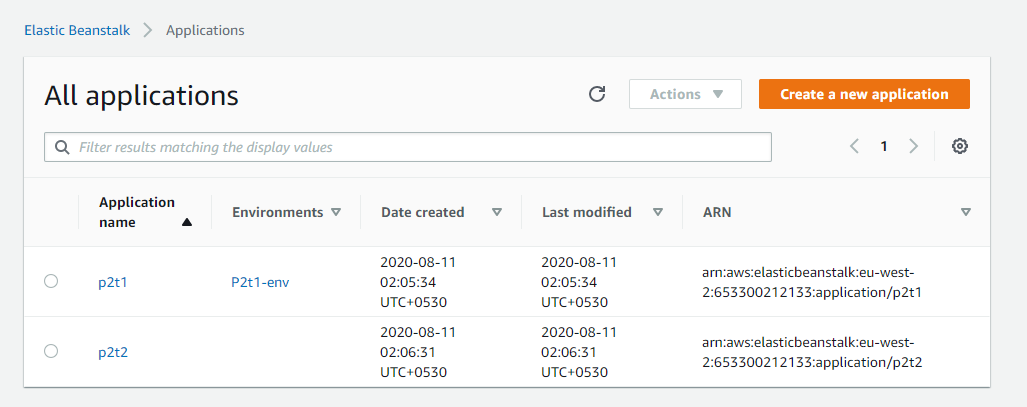